<a href="https://colab.research.google.com/github/aleksandr-del/kaggle-competitions/blob/main/season_3_episode_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kidney Stone Prediction based on Urine Analysis

![img](https://storage.googleapis.com/kaggle-datasets-images/2592962/4427082/a08ed65eb5f7adfdba2666f864cf8faf/dataset-cover.jpeg?t=2022-10-31-10-25-24)

Данные (обучающая и тестовая выборки) для этого [соревнования](https://www.kaggle.com/competitions/playground-series-s3e12/overview) были сгенерированы нейронной сетью, обученной на исходных данных [Kidney Stone Prediction based on Urine Analysis](https://www.kaggle.com/datasets/vuppalaadithyasairam/kidney-stone-prediction-based-on-urine-analysis). Распределения признаков близко к исходным.

У данных следующие признаки:

- `id` - уникальный номер наблюдения
- `gravity` -  относительная плотность (удельный вес) мочи
- `pH` - отрицательный десятичный логарифм концентрации ионов водорода: pH мочи
- `osmo` - осмолярность мочи
- `cond` - удельная электрическая проводимость мочи
- `urea` - концентрация мочевины в миллимолях на литр
- `calc` - концентрация кальция в моче
- `target` - целевой признак: 0- почечных камней нет, 1- почечные камни есть.

Метрика качества для оценки моделей: `AUC ROC`.
Цель соревнования: для каждого `id` в тестовой выборке предсказазать вероятность мочекаменной болезни.

## Загрузка и анализ данных

Импортируем необходимые библиотеки и модули:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ReLU

Загрузим обучающую и тестовую выборки:

In [ ]:
from google.colab import files

In [ ]:
files.upload()

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 /root/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c playground-series-s3e12

  0% 0.00/9.06k [00:00<?, ?B/s]
100% 9.06k/9.06k [00:00<00:00, 6.80MB/s]


Распакуем архивный файл:

In [ ]:
! unzip playground-series-s3e12.zip -d data

Archive:  playground-series-s3e12.zip
  inflating: data/sample_submission.csv  
  inflating: data/test.csv           
  inflating: data/train.csv          


Сохраним обучающую выборку в переменной `df` и выведим первые 5 строк таблицы:

In [ ]:
df = pd.read_csv('/content/data/train.csv')

In [ ]:
df.head()

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1


Общая информация:

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       414 non-null    int64  
 1   gravity  414 non-null    float64
 2   ph       414 non-null    float64
 3   osmo     414 non-null    int64  
 4   cond     414 non-null    float64
 5   urea     414 non-null    int64  
 6   calc     414 non-null    float64
 7   target   414 non-null    int64  
dtypes: float64(4), int64(4)
memory usage: 26.0 KB


В обучающей выборке 414 наблюдений. 6 признаков. Целевой признак - `target`. Пропуски отсутствуют. Значения всех признаков - количественные.

В переменной `X` сохраним список названий всех признаков, в переменной `y` - целевой признак:

In [ ]:
X = df.drop(columns=['id', 'target']).columns.tolist()
X

['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']

In [ ]:
y = 'target'
y

'target'

Краткая описательная статистка признаков:

In [ ]:
df[X].describe()

,gravity,ph,osmo,cond,urea,calc
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638
std,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641
min,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000
25%,1.012000,5.530000,455.250000,15.500000,170.000000,1.450000
50%,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000
75%,1.022000,6.280000,840.000000,27.600000,385.000000,6.630000
max,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000


Посмотрим на распределения признаков:

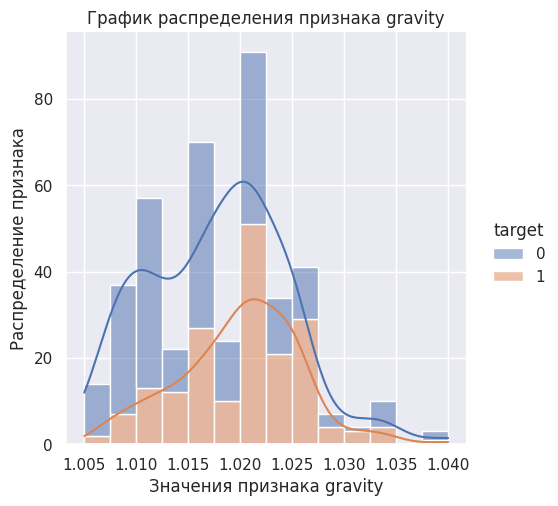

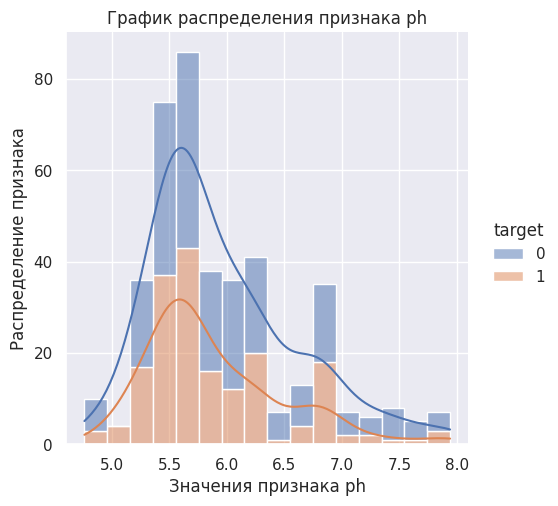

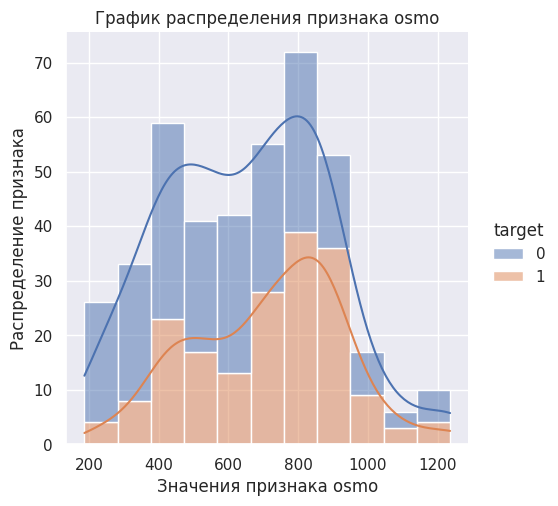

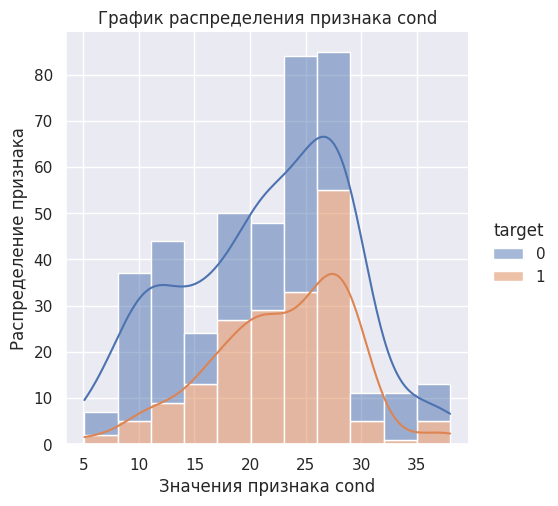

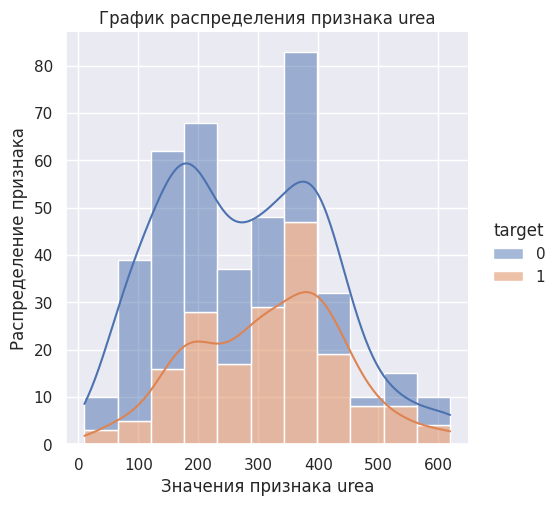

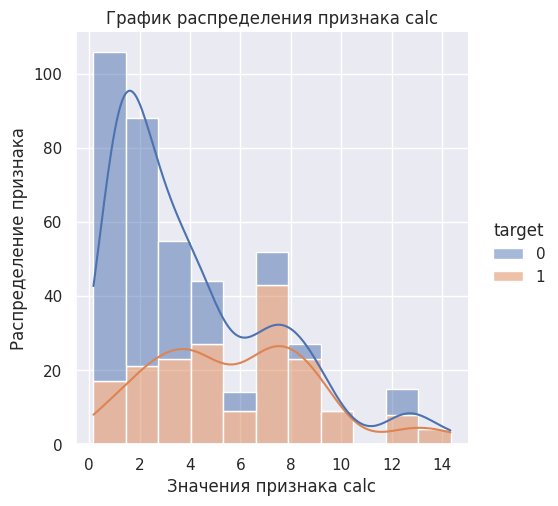

In [ ]:
for i in X:
    sns.displot(data=df, x=i, hue=y, multiple='stack', kde=True)
    plt.ylabel('Распределение признака')
    plt.xlabel(f'Значения признака {i}')
    plt.title(f'График распределения признака {i}')
    print()
    plt.show();

Посмотрим на баланс классов в обучающей выборке:

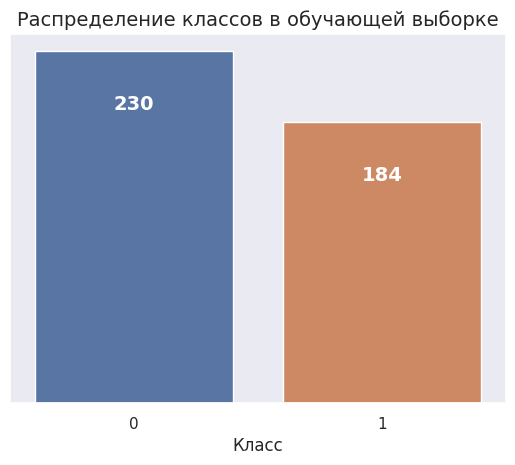

In [ ]:
ax = sns.countplot(x=df[y], 
                   order=df[y].value_counts(ascending=False).index)

ax.bar_label(container=ax.containers[0],
             labels=df[y].value_counts(ascending=False).values,
             padding=-45, color='white',
             fontsize=14, fontweight='bold')
ax.yaxis.set_visible(False)
plt.title('Распределение классов в обучающей выборке', fontsize=14)
plt.xlabel('Класс')
plt.show();

## Подготовка признаков

Создадим конвейер подготовки количественных признаков. Пропущенные значения, если они есть, будут заполняться медианой, значения признаков будут нормализованы:

In [ ]:
transformer = make_pipeline(SimpleImputer(strategy='median'),
                            StandardScaler())

Создадим `preprocessor` для подготовки всех данных:

In [ ]:
preprocessor = ColumnTransformer([('num', transformer, X)],
                                 verbose_feature_names_out=False)

## Обучение

### Логистическая регрессия

Создадим финальный конвейер для подготовки и обучения алгоритма:

In [ ]:
alg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('estimator', LogisticRegression(random_state=42))])

Создадим сетку гиперпараметров алгоритма логистической регрессии:

In [ ]:
parameters = {
    'estimator__penalty': ['l1', 'l2', 'elasticnet', None],
    'estimator__C': [0.01, 0.1, 0.5, 1, 2, 3, 5, 10],
    'estimator__solver': ['liblinear', 'saga'],
    'estimator__max_iter': [100, 300, 500, 1000],
    'estimator__multi_class': ['ovr']
}

In [ ]:
log_regr = GridSearchCV(alg,
                        parameters,
                        cv=5,
                        scoring='roc_auc',
                        n_jobs=2)

Обучим алгоритм логистической регрессии:

In [ ]:
log_regr.fit(df[X], df[y])

Лучшая метрика `ROC_AUC` модели логистической регрессии:

In [ ]:
log_regr.best_score_

0.7799418984201593

Лучшие параметры модели логистической регресссии:

In [ ]:
log_regr.best_params_

{'estimator__C': 0.1,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'ovr',
 'estimator__penalty': 'l1',
 'estimator__solver': 'saga'}

#### Submission для соревнования

Сохраним тестовую выборку в переменную `test`:

In [ ]:
test = pd.read_csv('/content/data/test.csv')

Выведим первые 5 строк:

In [ ]:
test.head()

,id,gravity,ph,osmo,cond,urea,calc
0,414,1.017,5.24,345,11.5,152,1.16
1,415,1.020,5.68,874,29.0,385,3.46
2,416,1.024,5.36,698,19.5,354,13.00
3,417,1.020,5.33,668,25.3,252,3.46
4,418,1.011,5.87,567,29.0,457,2.36


Общая информация:

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       276 non-null    int64  
 1   gravity  276 non-null    float64
 2   ph       276 non-null    float64
 3   osmo     276 non-null    int64  
 4   cond     276 non-null    float64
 5   urea     276 non-null    int64  
 6   calc     276 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 15.2 KB


Предсказание модели логистической регрессии вероятност принадлежности к первому классу:

In [ ]:
test_proba = log_regr.best_estimator_.predict_proba(test)[:, 1]

Запишем предсказанные вероятности в столбец `target`:

In [ ]:
test['target'] = test_proba

Запишем таблицу в файл для отправки решения на Kaggle:

In [ ]:
test[['id', 'target']].to_csv('submission.csv', index=None)

Промежуточный результат на тестовой выборке `=0.86333`

### Градиентный бустинг

Реализуем класс градиентного бустинга для задачи классификации:

In [ ]:
class MyGradientBoostingClassifier():
    def __init__(self, lr=0.01, iters=1000, max_depth=32):
        self.lr = lr
        self.iters = iters
        self.max_depth = max_depth
        self.models_ = None
        self.constant_prediction_ = None
        self.AUC_ = None

    def fit(self, X, y):
        X = X.values
        y = y.values
        pred_proba = np.full((y.shape), np.mean(y)) # инициализируем модель константным предсказанием: среднее значение таргета обучающей выборки
        models = [] # в этом списке будем хранить модели Решающего дерева
        AUC = [] # в этом списке будем хранить значение MSE каждой итерации

        for _ in range(self.iters):
            residual = y - pred_proba # считаем остатки
            model = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42) # инициализируем модель Решающего дерева
            model.fit(X, residual) # обучаемся на остатках
            pred_proba += model.predict(X) * self.lr # корректируем константное предсказание, компенсируя остатки
            models.append(model) # сохраняем модель в список моделей
            AUC.append(roc_auc_score(y, pred_proba)) # сохраняем метрику ROC-AUC
           
        self.models_ = models
        self.constant_prediction_ = np.mean(y)
        self.AUC_ = AUC

    def predict_proba(self, X):
        X = X.values
        pred_proba = np.full((X.shape[0]), self.constant_prediction_)

        for model in self.models_:
            pred_proba += model.predict(X) * self.lr
    
        return pred_proba

Кросс-валидацию градиентного бустинга проведем с помощью `KFold`, дополнительно будем перебирать гиперпараметр max_depth (глубина дерева) и количество итераций:

In [ ]:
cv = KFold(n_splits=5)

for iters in [100, 500, 1000, 1500, 2000, 3000, 5000]:
    for depth in [2, 4, 8, 16, 32]:
        AUC = []
        for train_index, valid_index in cv.split(df):
            mgbc = MyGradientBoostingClassifier(max_depth=depth, iters=iters, lr=0.001)
            X_train, y_train = df[X].loc[train_index], df[y].loc[train_index]
            X_valid, y_valid = df[X].loc[valid_index], df[y].loc[valid_index]
    
            mgbc.fit(X_train, y_train)
            pred_proba_valid = mgbc.predict_proba(X_valid)
            AUC.append(roc_auc_score(y_valid, pred_proba_valid))
        
        print(f'Глубина деревьев: {depth}. Количество итераций: {iters}. AUC: {np.mean(AUC)}.')

Глубина деревьев: 2. Количество итераций: 100. AUC: 0.7647375942516073.
Глубина деревьев: 4. Количество итераций: 100. AUC: 0.7155541331743728.
Глубина деревьев: 8. Количество итераций: 100. AUC: 0.6217106034746389.
Глубина деревьев: 16. Количество итераций: 100. AUC: 0.6295068431578354.
Глубина деревьев: 32. Количество итераций: 100. AUC: 0.6293902930412852.
Глубина деревьев: 2. Количество итераций: 500. AUC: 0.7784981931571417.
Глубина деревьев: 4. Количество итераций: 500. AUC: 0.7454264021608246.
Глубина деревьев: 8. Количество итераций: 500. AUC: 0.6500334241964405.
Глубина деревьев: 16. Количество итераций: 500. AUC: 0.6228901120037362.
Глубина деревьев: 32. Количество итераций: 500. AUC: 0.6262296296289681.
Глубина деревьев: 2. Количество итераций: 1000. AUC: 0.7810873081440084.
Глубина деревьев: 4. Количество итераций: 1000. AUC: 0.7625465188183095.
Глубина деревьев: 8. Количество итераций: 1000. AUC: 0.672700155360959.
Глубина деревьев: 16. Количество итераций: 1000. AUC: 0.62

Лучшая метрика `ROC-AUC` у модели с глубиной каждого дерева последовательности, равной 2, обученной на 1 000 итераций.

#### Submission для соревнования

Обучим алгоритм градиентного бустинга на лучших гиперпараметрах и на всей обучающей выборке:

In [ ]:
best_mgbc = MyGradientBoostingClassifier(max_depth=2, iters=1000, lr=0.001)

In [ ]:
best_mgbc.fit(df[X], df[y])

Визуализируем, как улучшалась метрика `ROC-AUC` на обучающей выборке с каждой последующей итерацией:

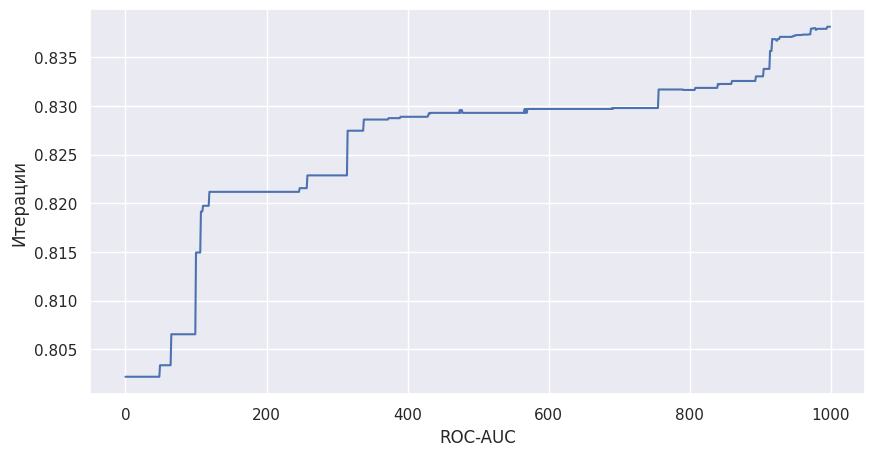

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(best_mgbc.AUC_)
plt.grid(True)
plt.xlabel('ROC-AUC')
plt.ylabel('Итерации')
plt.show()

Сохраним тестовую выборку в переменную `test`:

In [ ]:
test = pd.read_csv('/content/data/test.csv')

Предсказание модели градиентного бустинга вероятности принадлежности к первому классу:

In [ ]:
test_proba_mgbc = best_mgbc.predict_proba(test[X])

Запишем предсказанные вероятности в столбец `target`:

In [ ]:
test['target'] = test_proba_mgbc

Запишем таблицу в файл для отправки решения на Kaggle:

In [ ]:
test[['id', 'target']].to_csv('submission.csv', index=None)

Промежуточный результат на тестовой выборке `=0.86400`

### Нейронная сеть

Поделим обучающую выборку на валидационную и обучающую?

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(df[X], 
                                                      df[y], 
                                                      test_size=0.25, 
                                                      random_state=42)

Конвертируем обучающую и валидационную выборки в тензоры, предварительно предобработав признаки:

In [ ]:
preprocessor.fit(df[X])

In [ ]:
X_train_tensor = torch.tensor(preprocessor.transform(X_train), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values).reshape(-1, 1).to(torch.float32)

In [ ]:
X_valid_tensor = torch.tensor(preprocessor.transform(X_valid), dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.values).reshape(-1, 1).to(torch.float32)

Создадим нейросеть с несколькими скрытыми слоями и функцией активации ReLU:

In [ ]:
class MyClassifierNN(nn.Module):
    def __init__(self, hidden_neurons=18):
        super().__init__()
        
        self.layer_1 = nn.Linear(6, 12)
        self.layer_2 = nn.Linear(12, 1)

        

    def forward(self, X):
        y = F.relu(self.layer_1(X))
        y = F.relu(self.layer_2(y))
        output = y

        return output

Инициализируем модель:

In [ ]:
nn_model = MyClassifierNN()

Инициализируем оптимизатор:

In [ ]:
optimizer = torch.optim.Adam(params=nn_model.parameters(), lr=0.001)

Запускаем цикл обучения с перебором гиперпараметров нейросети:

In [ ]:
epochs = 1000
train_ROC_AUC = []
valid_ROC_AUC = []

for i in range(epochs):
    # считаем логиты: произведение матрицы признаков на матрицу весов
    logits = nn_model(X_train_tensor)
    # считаем вероятности
    proba = torch.sigmoid(logits)
    # вычисляем функцию потерь
    loss = torch.nn.functional.binary_cross_entropy(proba, y_train_tensor) 
    # вычисляем градиент
    loss.backward()
    # делаем шаг градиентного спуска: обновляем веса
    optimizer.step()
    # логируем значение метрики ROC-AUC
    auc = roc_auc_score(y_train, np.ravel(proba.detach().numpy()))
    train_ROC_AUC.append(auc)
    # обнуляем градиенты для следующего шага
    optimizer.zero_grad()

    #валидация на валидационной выборке
    val_logits = nn_model(X_valid_tensor)
    val_proba = torch.sigmoid(val_logits)
    val_auc = roc_auc_score(y_valid, np.ravel(val_proba.detach().numpy()))
    valid_ROC_AUC.append(val_auc)

    if auc - val_auc > 0.03:
        break
print(f'Количество эпох до остановки: {i}.')

Количество эпох до остановки: 583.


Визуализируем, как изменялись метрика качества на обучающей и валидационной выборке:

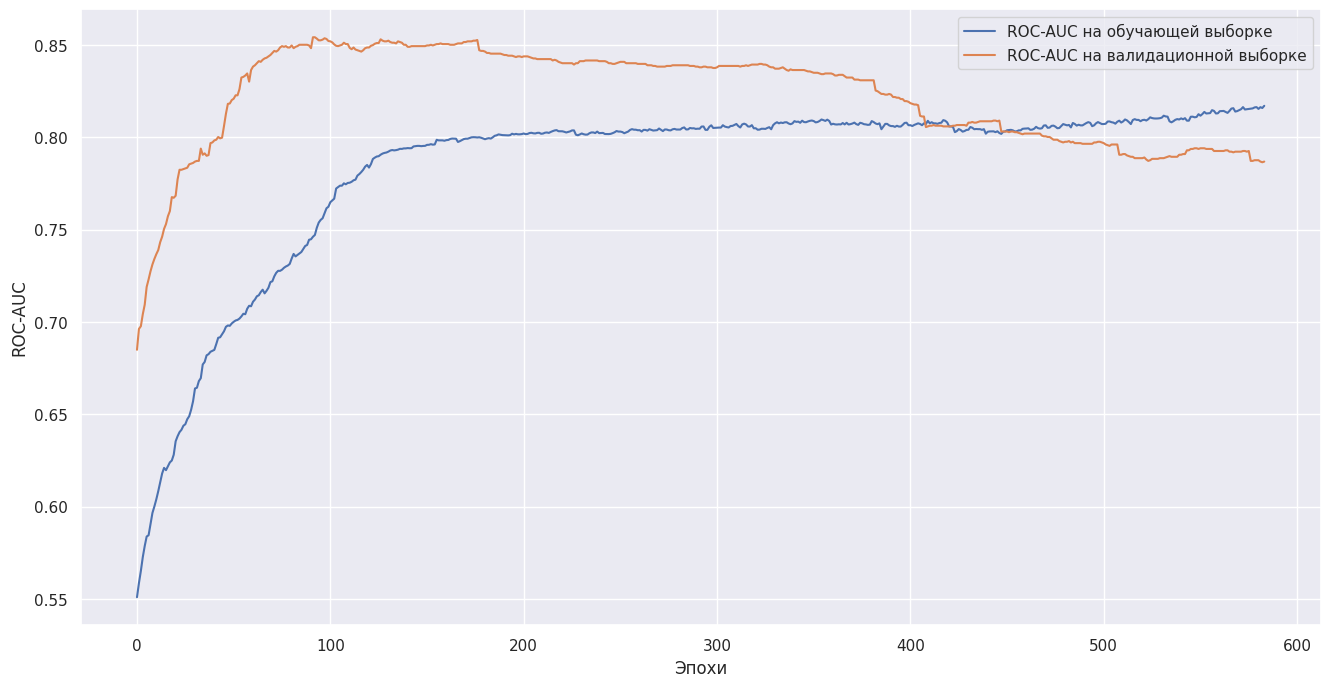

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(train_ROC_AUC, label='ROC-AUC на обучающей выборке')
plt.plot(valid_ROC_AUC, label='ROC-AUC на валидационной выборке')
plt.xlabel('Эпохи')
plt.ylabel('ROC-AUC')
plt.legend()
plt.yticks()
plt.show()

#### Submission для соревнования

Подготовим полную обучающую выборку:

In [ ]:
X_train_tensor_full = torch.tensor(preprocessor.fit_transform(df[X]), dtype=torch.float32)
y_train_tensor_full = torch.tensor(df[y].values).reshape(-1, 1).to(torch.float32)

Сохраним тестовую выборку в переменную `test`:

In [ ]:
test = pd.read_csv('/content/data/test.csv')

Конвертируем тестовую выборку в тензор, предварительно предобработав признаки:

In [ ]:
X_test_tensor = torch.tensor(preprocessor.transform(test[X]), dtype=torch.float32)

Обучим нейросеть на всей обучающей выборке. Инициализируем модель:

In [ ]:
best_nn = MyClassifierNN()

Инициализируем оптимизатор:

In [ ]:
optimizer = torch.optim.Adam(params=best_nn.parameters(), lr=0.001)

Запускаем цикл обучения:

In [ ]:
epochs = 100

for i in range(epochs):
    # считаем логиты: произведение матрицы признаков на матрицу весов
    logits = best_nn(X_train_tensor_full)
    # считаем вероятности
    proba = torch.sigmoid(logits)
    # вычисляем функцию потерь
    loss = torch.nn.functional.binary_cross_entropy(proba, y_train_tensor_full) 
    # вычисляем градиент
    loss.backward()
    # делаем шаг градиентного спуска: обновляем веса
    optimizer.step()
    # обнуляем градиенты для следующего шага
    optimizer.zero_grad()

Пропустим выходы через сигмоиду и предскажем вероятности принадлежности к 1-му классу для тестовой выборки:

In [ ]:
# посчитаем логиты
test_logits = best_nn(X_test_tensor)
# подадим логиты сигмоидной функции и посчитаем вероятности первого класса
test_proba = np.ravel(torch.sigmoid(test_logits).detach().numpy())

Запишем предсказанные вероятности в столбец `target`:

In [ ]:
test['target'] = test_proba

Запишем таблицу в файл для отправки решения на Kaggle:

In [ ]:
test[['id', 'target']].to_csv('submission.csv', index=None)

Промежуточный результат на тестовой выборке `0.84266`

## Результаты соревнования

#### Соревнование завершено 18 апреля 2023 г. 426 место из 1 088 с итоговым score `=0.75455`. Score лидера соревнования `=0.76789`.